In [1]:
import os
import re
import gc
import multiprocessing
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_from_disk, Dataset, DatasetDict  
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = "nlp_classification_tasks/"
conditions = ["x", "y", "z"]
time_slice = "a"

In [3]:
val_size = 0.1
seed = 22
cols = ["text", "label"]
max_seq_len = 8192

In [4]:
bioclinroberta_path = 'RoBERTa-base-PM-M3-Voc-distill-align-hf/'
tokenizer = AutoTokenizer.from_pretrained(bioclinroberta_path)

In [5]:
def plot_token_len_distribution(dataset):

    plt.hist([len(ids) for ids in dataset['input_ids']], bins=50)
    plt.ylabel("Frequency")
    plt.xlabel("Tokens per Patient")
    plt.title("Distribution of Tokens per Patient")
    plt.show()

In [6]:
def tokenize_text(record, tokenizer, truncate_to):
    
    return {
        'input_ids': tokenizer(
            record['text'],
            padding=False,
            truncation=True,
            max_length=truncate_to
        )['input_ids']
    }

In [7]:
def tokenize_plot(dataset, tokenizer, truncate_to, batch_size=512, proc_div=2):
    
    num_proc = int(multiprocessing.cpu_count() / proc_div)
    print(f"Tokenizing with {num_proc} CPU processes...")
    
    dataset = dataset.map(
        tokenize_text,
        batched=True,
        batch_size=batch_size,
        fn_kwargs={
            "tokenizer": tokenizer,
            "truncate_to": truncate_to
        },
        num_proc=num_proc
    )
    
    plot_token_len_distribution(dataset)
    dataset.remove_columns('input_ids')
    gc.collect()

In [8]:
def split_on_sole_pipe(input_string):  
    
    return re.split(r'(?<! )\|(?![ |])', input_string) 

In [9]:
def remove_duplicates_join_on_sep(text):
    
    notes = []
    for note in split_on_sole_pipe(text):
        if not note in notes:
            notes.append(note)
            
    return tokenizer.sep_token.join(notes)

Processing data for falls...
Train size: 73248
Val size: 8139
Test size: 28898
Tokenizing with 12 CPU processes...


Map (num_proc=12): 100%|██████████| 73248/73248 [00:10<00:00, 6964.69 examples/s] 


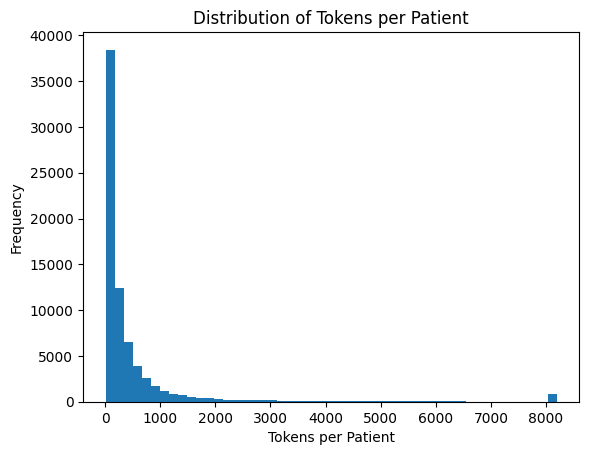

Saving the dataset (1/1 shards): 100%|██████████| 28898/28898 [00:01<00:00, 22993.47 examples/s]


Processing data for frailty...
Train size: 41978
Val size: 4665
Test size: 4483
Tokenizing with 12 CPU processes...


Map (num_proc=12): 100%|██████████| 41978/41978 [00:07<00:00, 5806.34 examples/s] 


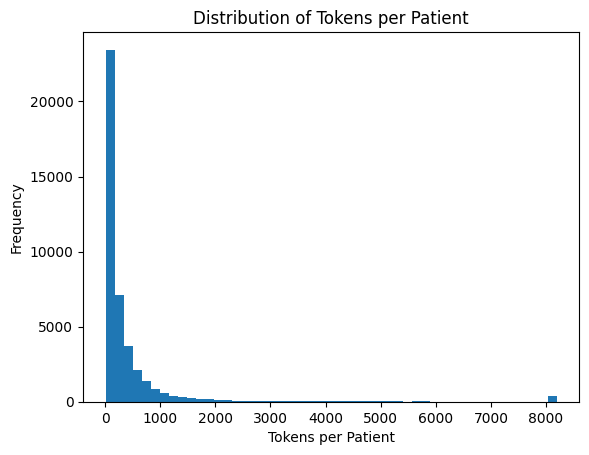

Saving the dataset (1/1 shards): 100%|██████████| 4483/4483 [00:00<00:00, 31687.16 examples/s]


Processing data for mortality...
Train size: 34459
Val size: 3829
Test size: 6637
Tokenizing with 12 CPU processes...


Map (num_proc=12): 100%|██████████| 34459/34459 [00:07<00:00, 4543.71 examples/s]


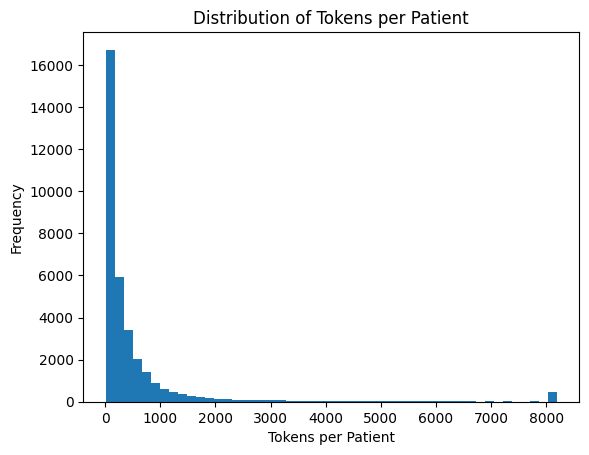

Saving the dataset (1/1 shards): 100%|██████████| 6637/6637 [00:00<00:00, 26327.15 examples/s]


Processing data for ckd2345_2022_nlp...
Train size: 18577
Val size: 2065
Test size: 2887
Tokenizing with 12 CPU processes...


Map (num_proc=12): 100%|██████████| 18577/18577 [00:03<00:00, 5233.59 examples/s] 


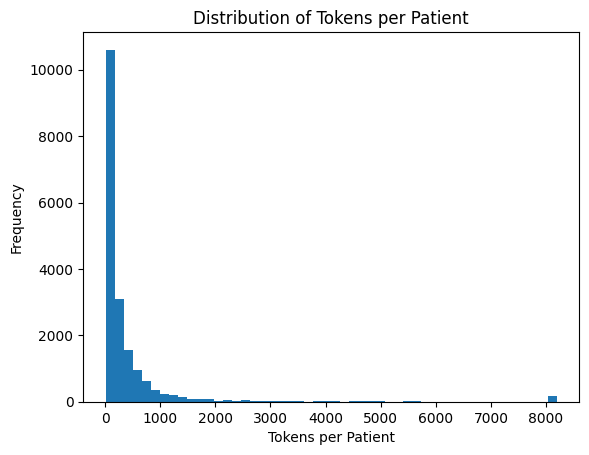

Saving the dataset (1/1 shards): 100%|██████████| 2887/2887 [00:00<00:00, 11546.38 examples/s]


In [10]:
for condition in conditions:
    
    # Load dataset
    print(f"Processing data for {condition}...")
    dataset_name = f"{time_slice}_{condition}_ids_text_feats_concatenated.hf"
    d = load_from_disk(os.path.join(data_dir, dataset_name))
    
    # Convert to dataframes and create validation split
    train_df = d['train'].to_pandas()
    test_df = d['test'].to_pandas()
    train_df, val_df = train_test_split(train_df, test_size=val_size, random_state=seed, stratify=train_df['label'].values)
    
    # Select text, and label columns
    train_df, val_df, test_df = train_df[cols], val_df[cols], test_df[cols]
    
    # Remove duplicate notes
    train_df['text'] = train_df['text'].apply(remove_duplicates_join_on_sep)
    val_df['text'] = val_df['text'].apply(remove_duplicates_join_on_sep)
    test_df['text'] = test_df['text'].apply(remove_duplicates_join_on_sep)
    
    # Count data split sizes
    print(f"Train size: {train_df.shape[0]}")
    print(f"Val size: {val_df.shape[0]}")
    print(f"Test size: {test_df.shape[0]}")
    
    # Create new HF datasets
    train_dataset = Dataset.from_pandas(train_df)  
    val_dataset = Dataset.from_pandas(val_df)  
    test_dataset = Dataset.from_pandas(test_df)
    
    # View token length distribution
    tokenize_plot(train_dataset, tokenizer, truncate_to=max_seq_len)
    
    # Create new dataset dict
    dataset_dict = {  
        "train": train_dataset,  
        "val": val_dataset,  
        "test": test_dataset  
    }  
    dataset_dict = DatasetDict(dataset_dict)  
    
    # Save dataset dict
    new_dataset_name = f"{time_slice}_{condition}_text_label.hf"
    dataset_dict.save_to_disk(os.path.join(data_dir, new_dataset_name))